In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# Добавим XGBoost, LightGBM и CatBoost
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

In [4]:
# Для Target Encoding
try:
    from category_encoders import TargetEncoder
except ImportError:
    print("Библиотека category_encoders не установлена. Устанавливаем её...")
    !pip install category_encoders
    from category_encoders import TargetEncoder

## Загрузка данных

In [5]:
data = pd.read_csv('dataset.csv')

In [6]:
# Выводим список столбцов для диагностики
print("Столбцы в данных:")
print(data.columns.tolist())

# Если 'Unnamed: 0' является индексом, загрузим с index_col=0
if 'Unnamed: 0' in data.columns:
    data = pd.read_csv('dataset.csv', index_col=0)
    print("'Unnamed: 0' загружен как индекс.")
else:
    print("'Unnamed: 0' отсутствует в данных. Продолжаем без него.")

Столбцы в данных:
['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name', 'popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'track_genre']
'Unnamed: 0' загружен как индекс.


## EDA (Исследовательский анализ данных)

In [7]:
print("\nПервый взгляд на данные:")
display(data.head())
print("\nИнформация о данных:")
data.info()
print("\nОписание числовых признаков:")
display(data.describe())

print("\nКоличество пропусков:")
print(data.isnull().sum())


Первый взгляд на данные:


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic



Информация о данных:
<class 'pandas.core.frame.DataFrame'>
Index: 114000 entries, 0 to 113999
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   track_id          114000 non-null  object 
 1   artists           113999 non-null  object 
 2   album_name        113999 non-null  object 
 3   track_name        113999 non-null  object 
 4   popularity        114000 non-null  int64  
 5   duration_ms       114000 non-null  int64  
 6   explicit          114000 non-null  bool   
 7   danceability      114000 non-null  float64
 8   energy            114000 non-null  float64
 9   key               114000 non-null  int64  
 10  loudness          114000 non-null  float64
 11  mode              114000 non-null  int64  
 12  speechiness       114000 non-null  float64
 13  acousticness      114000 non-null  float64
 14  instrumentalness  114000 non-null  float64
 15  liveness          114000 non-null  float64
 16  val

,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,114000.000000,1.140000e+05,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000
mean,33.238535,2.280292e+05,0.566800,0.641383,5.309140,-8.258960,0.637553,0.084652,0.314910,0.156050,0.213553,0.474068,122.147837,3.904035
std,22.305078,1.072977e+05,0.173542,0.251529,3.559987,5.029337,0.480709,0.105732,0.332523,0.309555,0.190378,0.259261,29.978197,0.432621
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-49.531000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17.000000,1.740660e+05,0.456000,0.472000,2.000000,-10.013000,0.000000,0.035900,0.016900,0.000000,0.098000,0.260000,99.218750,4.000000
50%,35.000000,2.129060e+05,0.580000,0.685000,5.000000,-7.004000,1.000000,0.048900,0.169000,0.000042,0.132000,0.464000,122.017000,4.000000
75%,50.000000,2.615060e+05,0.695000,0.854000,8.000000,-5.003000,1.000000,0.084500,0.598000,0.049000,0.273000,0.683000,140.071000,4.000000
max,100.000000,5.237295e+06,0.985000,1.000000,11.000000,4.532000,1.000000,0.965000,0.996000,1.000000,1.000000,0.995000,243.372000,5.000000



Количество пропусков:
track_id            0
artists             1
album_name          1
track_name          1
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64


In [8]:
# Проверка наличия нулевых значений в целевой переменной
target_col = 'popularity'
if target_col in data.columns:
    print(f"\nКоличество нулевых значений в целевой переменной '{target_col}':", (data[target_col] == 0).sum())
else:
    print(f"\nЦелевая переменная '{target_col}' отсутствует в данных.")
    # Здесь можно добавить логику для обработки отсутствующей целевой переменной


Количество нулевых значений в целевой переменной 'popularity': 16020


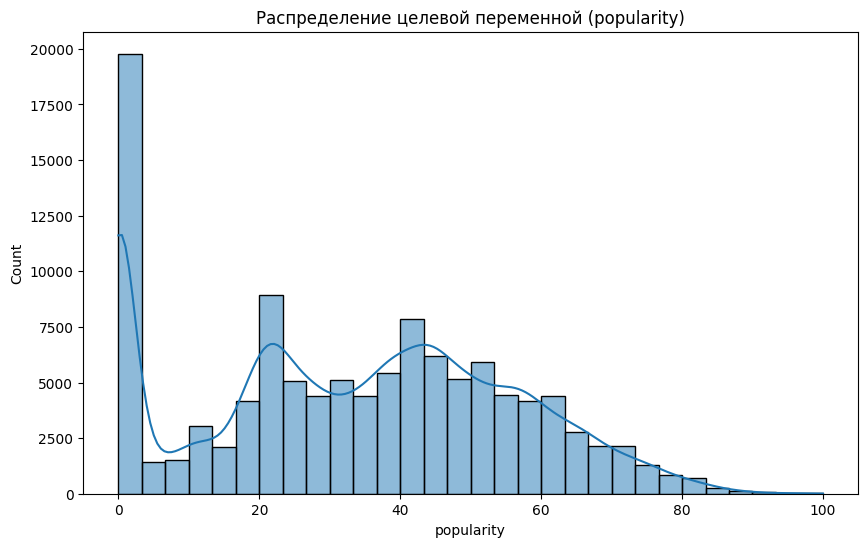

In [9]:
# Распределение целевой переменной
if target_col in data.columns:
    plt.figure(figsize=(10,6))
    sns.histplot(data[target_col], kde=True, bins=30)
    plt.title(f'Распределение целевой переменной ({target_col})')
    plt.show()
else:
    print(f"Пропускаем построение распределения для отсутствующей целевой переменной '{target_col}'.")

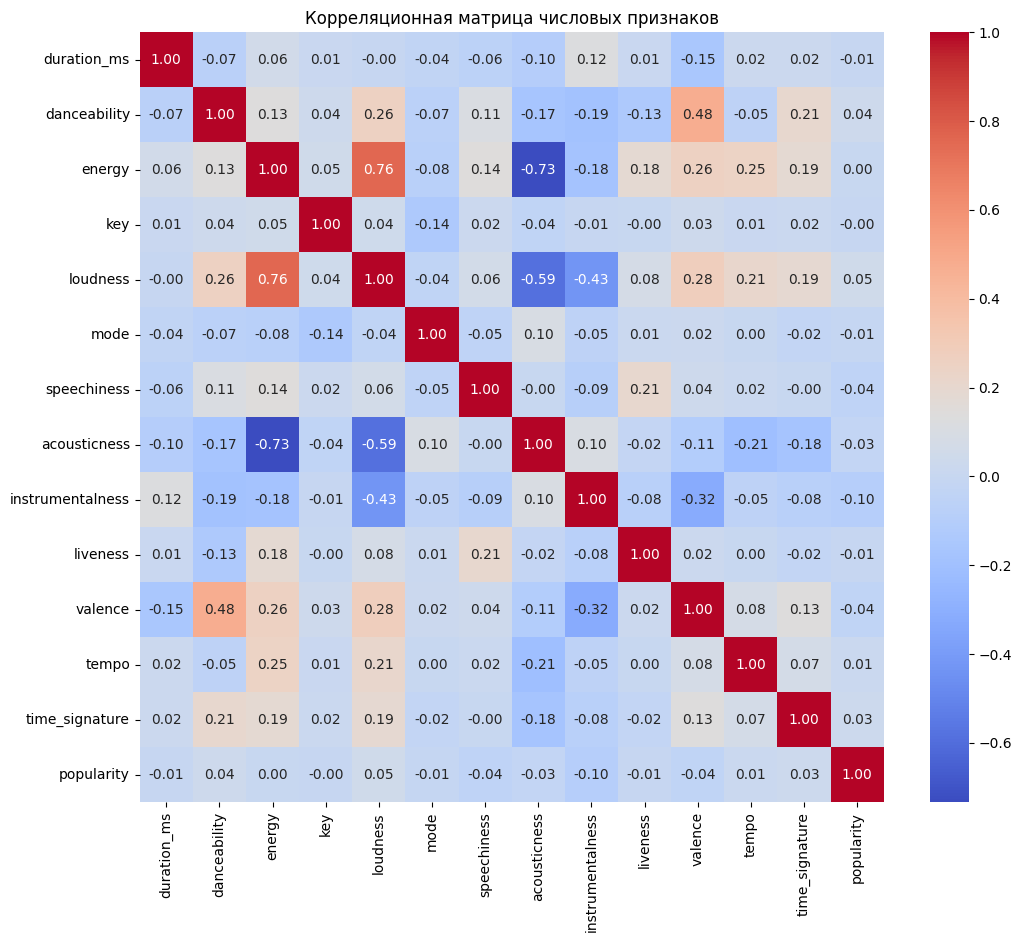

Корреляции признаков с целью:
popularity          1.000000
loudness            0.050423
danceability        0.035448
time_signature      0.031073
tempo               0.013205
energy              0.001056
key                -0.003853
liveness           -0.005387
duration_ms        -0.007101
mode               -0.013931
acousticness       -0.025472
valence            -0.040534
speechiness        -0.044927
instrumentalness   -0.095139
Name: popularity, dtype: float64


In [10]:
# Корреляция числовых признаков
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
if target_col in numeric_cols:
    numeric_cols.remove(target_col)  # Удаляем целевую переменную

if target_col in data.columns:
    corr_matrix = data[numeric_cols + [target_col]].corr()
    plt.figure(figsize=(12,10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Корреляционная матрица числовых признаков')
    plt.show()

    print("Корреляции признаков с целью:")
    print(corr_matrix[target_col].sort_values(ascending=False))
else:
    print("Целевая переменная отсутствует, пропускаем построение корреляционной матрицы.")

## Обработка выбросов

In [11]:
from scipy import stats

if target_col in data.columns:
    # Обновляем список числовых признаков после возможного удаления целевой переменной
    numeric_cols = [col for col in numeric_cols if col != target_col]
else:
    numeric_cols = numeric_cols  # Без изменения

if len(numeric_cols) > 0:
    # Определим порог Z-score
    z_threshold = 3
    z_scores = np.abs(stats.zscore(data[numeric_cols]))
    outliers = (z_scores > z_threshold).any(axis=1)
    print(f"Количество выбросов: {outliers.sum()}")

    # Удаляем выбросы
    data = data[~outliers]
    print("После удаления выбросов форма данных:", data.shape)
else:
    print("Нет числовых признаков для обработки выбросов.")

Количество выбросов: 9289
После удаления выбросов форма данных: (104711, 20)


## Очистка данных и обработка пропусков

In [12]:
# Удаляем ненужные столбцы
columns_to_drop = ['track_id']  # 'Unnamed: 0' уже удалён через index_col
existing_columns_to_drop = [col for col in columns_to_drop if col in data.columns]
X = data.drop(columns=existing_columns_to_drop + [target_col] if target_col in data.columns else [])
y = data[target_col] if target_col in data.columns else None

if y is not None:
    # Убедимся, что y не содержит NaN
    if y.isnull().sum() > 0:
        print(f"Целевая переменная '{target_col}' содержит пропуски. Выполняем удаление соответствующих строк.")
        non_null_indices = y.notnull()
        X = X[non_null_indices]
        y = y[non_null_indices]
else:
    print("Целевая переменная не задана. Необходимо определить y для обучения моделей.")

In [13]:
# Теперь определим числовые и категориальные признаки на основе оставшихся данных
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()

print(f"\nЧисловые признаки: {numeric_cols}")
print(f"Категориальные признаки: {categorical_cols}")


Числовые признаки: ['duration_ms', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']
Категориальные признаки: ['artists', 'album_name', 'track_name', 'track_genre']


In [14]:
# Создаем трансформеры для числовых и категориальных данных
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Используем Target Encoding для категориальных признаков, если они есть
if len(categorical_cols) > 0:
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('target_encoder', TargetEncoder())
    ])
else:
    categorical_transformer = None
    print("Нет категориальных признаков для кодирования.")

In [15]:
# Создаём список трансформеров для ColumnTransformer
transformers = []
if len(numeric_cols) > 0:
    transformers.append(('num', numeric_transformer, numeric_cols))
if categorical_transformer is not None:
    transformers.append(('cat', categorical_transformer, categorical_cols))

preprocessor = ColumnTransformer(
    transformers=transformers
)

## Отделение обучающей и тестовой выборки

In [16]:
if y is not None:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
else:
    X_train, X_test, y_train, y_test = None, None, None, None
    print("Необходимо определить y для разделения данных на обучающую и тестовую выборки.")

## Построение пайплайна с предварительной обработкой и моделями

In [17]:
# Определяем модели и их гиперпараметры для GridSearch и RandomizedSearch
models = {
    "LinearRegression": {
        "model": LinearRegression(),
        "params": {}
    },
    "DecisionTree": {
        "model": DecisionTreeRegressor(random_state=42),
        "params": {
            'model__max_depth': [None, 10, 20, 30, 40, 50],
            'model__min_samples_split': [2, 5, 10, 20],
            'model__min_samples_leaf': [1, 2, 4, 8]
        }
    },
    "RandomForest": {
        "model": RandomForestRegressor(random_state=42),
        "params": {
            'model__n_estimators': [100, 200, 300],
            'model__max_depth': [None, 10, 20, 30],
            'model__min_samples_split': [2, 5, 10],
            'model__min_samples_leaf': [1, 2, 4]
        }
    },
    "GradientBoosting": {
        "model": GradientBoostingRegressor(random_state=42),
        "params": {
            'model__n_estimators': [100, 200, 300],
            'model__learning_rate': [0.01, 0.05, 0.1],
            'model__max_depth': [3, 5, 7],
            'model__subsample': [0.7, 0.8, 0.9, 1.0]
        }
    },
    "XGBoost": {
        "model": xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
        "params": {
            'model__n_estimators': [100, 200, 300],
            'model__learning_rate': [0.01, 0.05, 0.1],
            'model__max_depth': [3, 5, 7],
            'model__subsample': [0.7, 0.8, 0.9, 1.0]
        }
    },
    "LightGBM": {
        "model": lgb.LGBMRegressor(random_state=42),
        "params": {
            'model__n_estimators': [100, 200, 300],
            'model__learning_rate': [0.01, 0.05, 0.1],
            'model__max_depth': [3, 5, 7, -1],
            'model__num_leaves': [31, 50, 100]
        }
    },
    "CatBoost": {
        "model": CatBoostRegressor(verbose=0, random_state=42),
        "params": {
            'model__iterations': [500, 1000],
            'model__learning_rate': [0.01, 0.05, 0.1],
            'model__depth': [4, 6, 8, 10]
        }
    }
}

In [18]:
# Функция для создания пайплайна
def create_pipeline(model):
    return Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])


## Гиперпараметрическая настройка и кросс-валидация

In [19]:
results = {}
best_estimators = {}

for name, config in models.items():
    print(f"\nНастройка гиперпараметров для модели: {name}")
    pipeline = create_pipeline(config['model'])
    param_grid = config['params']
    
    if param_grid:
        # Используем RandomizedSearchCV для ускорения поиска
        search = RandomizedSearchCV(
            pipeline, 
            param_grid, 
            n_iter=20, 
            cv=5, 
            scoring='neg_mean_squared_error',
            verbose=1, 
            random_state=42, 
            n_jobs=-1
        )
        search.fit(X_train, y_train)
        best_rmse = np.sqrt(-search.best_score_)
        results[name] = best_rmse
        best_estimators[name] = search.best_estimator_
        print(f"{name}: Лучшие параметры: {search.best_params_}, RMSE на кросс-валидации = {best_rmse}")
    else:
        # Для моделей без гиперпараметров (например, LinearRegression)
        pipeline.fit(X_train, y_train)
        cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
        mean_mse = -cv_scores.mean()
        rmse = np.sqrt(mean_mse)
        results[name] = rmse
        best_estimators[name] = pipeline
        print(f"{name}: RMSE на кросс-валидации = {rmse}")


Настройка гиперпараметров для модели: LinearRegression
LinearRegression: RMSE на кросс-валидации = 13.893599096469625

Настройка гиперпараметров для модели: DecisionTree
Fitting 5 folds for each of 20 candidates, totalling 100 fits
DecisionTree: Лучшие параметры: {'model__min_samples_split': 20, 'model__min_samples_leaf': 8, 'model__max_depth': 10}, RMSE на кросс-валидации = 12.220337310507203

Настройка гиперпараметров для модели: RandomForest
Fitting 5 folds for each of 20 candidates, totalling 100 fits
RandomForest: Лучшие параметры: {'model__n_estimators': 300, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_depth': 30}, RMSE на кросс-валидации = 11.462469757198033

Настройка гиперпараметров для модели: GradientBoosting
Fitting 5 folds for each of 20 candidates, totalling 100 fits
GradientBoosting: Лучшие параметры: {'model__subsample': 1.0, 'model__n_estimators': 300, 'model__max_depth': 5, 'model__learning_rate': 0.1}, RMSE на кросс-валидации = 11.648638

## Кросс-валидация и обучение нейросети

In [48]:
def build_nn(input_dim):
    model = keras.Sequential([
        keras.layers.Dense(256, activation='relu', input_shape=(input_dim,)),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [49]:
# Применяем предварительную обработку к данным для нейросети
X_train_preprocessed = preprocessor.fit_transform(X_train, y_train)  # Передаём y_train
X_test_preprocessed = preprocessor.transform(X_test)

In [50]:
# Настройка KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [53]:
nn_rmse_scores = []
nn_mae_scores = []
best_nn_model = None

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_preprocessed, y_train)):
    print(f"Обучение нейросети: Фолд {fold + 1}")
    X_tr, X_val = X_train_preprocessed[train_idx], X_train_preprocessed[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    nn_model = build_nn(X_train_preprocessed.shape[1])
    early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    nn_model.fit(
        X_tr, y_tr, 
        epochs=10, 
        batch_size=32, 
        validation_data=(X_val, y_val), 
        callbacks=[early_stop], 
        verbose=0
    )
    y_pred_val = nn_model.predict(X_val).ravel()
    mse_val = mean_squared_error(y_val, y_pred_val)
    mae_val = mean_absolute_error(y_val, y_pred_val)
    nn_rmse_scores.append(np.sqrt(mse_val))
    nn_mae_scores.append(mae_val)
    print(f"Фолд {fold + 1}: RMSE = {np.sqrt(mse_val)}, MAE = {mae_val}")

Обучение нейросети: Фолд 1
524/524 [==============================] - 1s 2ms/step
Фолд 1: RMSE = 5.644998351332722, MAE = 4.168732248443229
Обучение нейросети: Фолд 2
524/524 [==============================] - 1s 2ms/step
Фолд 2: RMSE = 5.369709579957913, MAE = 3.666078964355696
Обучение нейросети: Фолд 3
524/524 [==============================] - 1s 2ms/step
Фолд 3: RMSE = 5.97505182033865, MAE = 4.143059167871757
Обучение нейросети: Фолд 4
524/524 [==============================] - 1s 2ms/step
Фолд 4: RMSE = 6.482891522512151, MAE = 5.02469667159201
Обучение нейросети: Фолд 5
524/524 [==============================] - 1s 2ms/step
Фолд 5: RMSE = 5.588746568912481, MAE = 3.6936788744715257


In [77]:
y_pred_test = nn_model.predict(X_test_preprocessed).ravel()
mse_test = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse_test)

655/655 [==============================] - 1s 2ms/step


In [78]:
nn_rmse_mean = rmse #np.mean(nn_rmse_scores)
nn_mae_mean = np.mean(nn_mae_scores)
results["NeuralNetwork"] = nn_rmse_mean
best_estimators["NeuralNetwork"] = nn_model  # Сохраняем модель нейросети

print(f"\nNeuralNetwork: Средний RMSE на кросс-валидации = {nn_rmse_mean}")
print(f"NeuralNetwork: Средний MAE на кросс-валидации = {nn_mae_mean}")


NeuralNetwork: Средний RMSE на кросс-валидации = 11.336246714623021
NeuralNetwork: Средний MAE на кросс-валидации = 2.961320461462148


## Обучение другой нейронки

In [20]:
import torch
from torch import nn
from torch.nn import functional as F

device = torch.device('cuda')

In [56]:
class Model(nn.Module):
    def __init__(self, num_features, max_out_val=100, scale=1.0, hidden_dim=64):
        super().__init__()
        self.norm = nn.BatchNorm1d(num_features)
        self.fc1 = nn.Linear(num_features, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, max_out_val + 1)
        self.act = nn.SiLU()
        self.drop = nn.Dropout(0.1)
        self.max_out_val = max_out_val
        self.scale = scale

    def forward(self, feats):
        x = self.norm(feats)
        x = self.act(self.fc1(x))
        x = self.drop(x)
        x = self.act(self.fc2(x))
        x = self.fc3(x)
        
        value_probs = F.softmax(x, dim=-1)
        values = torch.arange(0, self.max_out_val+1, device=x.device)
        return self.scale * torch.sum(value_probs * values, dim=-1)

def create_model(num_features):
    model = Model(num_features, hidden_dim=16, max_out_val=50, scale=2).to(device)
    loss_fn = nn.HuberLoss()
    opt = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
    # opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, opt

In [41]:
def eval_on_test(model, batch_sz=64):
    losses = []
    model.eval()
    with torch.inference_mode():
        for idx in range(0, X_test.shape[0], batch_sz):
            batch_in = pd_to_torch(X_test[idx:idx+batch_sz])
            batch_out = pd_to_torch(y_test[idx:idx+batch_sz])
            loss_val = loss_fn(model(batch_in), batch_out)
            losses.append(loss_val.detach().cpu().item())
    return sum(losses) / len(losses)

In [42]:
def pd_to_torch(frame):
    return torch.tensor(np.array(frame, dtype=np.float32), device=device)

In [70]:
nn_rmse_scores = []
nn_mae_scores = []

batch_sz = 128
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_preprocessed, y_train)):
    print(f"Обучение нейросети: Фолд {fold + 1}")
    X_tr, X_val = X_train_preprocessed[train_idx], X_train_preprocessed[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model, loss_fn, opt = create_model(X_tr.shape[1])
    for epoch in range(40):
        model.train()
        losses = []
        for idx in range(0, X_tr.shape[0], batch_sz):
            batch_in = pd_to_torch(X_tr[idx:idx+batch_sz])
            batch_out = pd_to_torch(y_tr[idx:idx+batch_sz])
            
            loss_val = loss_fn(model(batch_in), batch_out)
            
            opt.zero_grad()
            loss_val.backward()
            opt.step()
            
            losses.append(loss_val.detach().cpu().item())
    
        # train_loss = sum(losses) / len(losses)
        # test_loss = eval_on_test(model, batch_sz)

    model.eval()
    with torch.inference_mode():
        y_pred_val = model(pd_to_torch(X_val)).cpu()
    
    mse_val = mean_squared_error(y_val, y_pred_val)
    mae_val = mean_absolute_error(y_val, y_pred_val)
    nn_rmse_scores.append(np.sqrt(mse_val))
    nn_mae_scores.append(mae_val)
    print(f"Фолд {fold + 1}: RMSE = {np.sqrt(mse_val)}, MAE = {mae_val}")

Обучение нейросети: Фолд 1
Фолд 1: RMSE = 5.325492798817084, MAE = 3.5034775148503066
Обучение нейросети: Фолд 2
Фолд 2: RMSE = 5.06926879455896, MAE = 2.7208207974945364
Обучение нейросети: Фолд 3
Фолд 3: RMSE = 5.327676420796377, MAE = 3.2129474526389736
Обучение нейросети: Фолд 4
Фолд 4: RMSE = 5.17983391196155, MAE = 2.828749616730804
Обучение нейросети: Фолд 5
Фолд 5: RMSE = 5.12547533931666, MAE = 2.540606925596119


In [74]:
batch_in = pd_to_torch(X_test_preprocessed)
batch_out = pd_to_torch(y_test)

model.eval()
with torch.inference_mode():
    pred = model(batch_in)

with torch.inference_mode():
    err = (pred - batch_out)
    rmse = np.sqrt((err * err).mean().cpu().numpy())

rmse

11.521602

In [75]:
nn_rmse_mean = rmse #np.mean(nn_rmse_scores)
nn_mae_mean = np.mean(nn_mae_scores)
results["NeuralNetwork2"] = nn_rmse_mean
best_estimators["NeuralNetwork2"] = model  # Сохраняем модель нейросети

print(f'NeuralNetwork2: Средний RMSE на кросс-валидации = {nn_rmse_mean}')
print(f'NeuralNetwork2: Средний MAE на кросс-валидации = {nn_mae_mean}')

NeuralNetwork2: Средний RMSE на кросс-валидации = 11.521601676940918
NeuralNetwork2: Средний MAE на кросс-валидации = 2.961320461462148


## Выбор лучшей модели

In [79]:
best_model_name = min(results, key=results.get)
print(f"\nЛучшая модель по результатам кросс-валидации: {best_model_name} с RMSE = {results[best_model_name]}")


Лучшая модель по результатам кросс-валидации: NeuralNetwork с RMSE = 11.336246714623021


## Обучение лучшей модели на всех тренировочных данных и оценка на тесте

In [80]:
if best_model_name != "NeuralNetwork":
    final_model = best_estimators[best_model_name]
    final_model.fit(X_train, y_train)
    y_pred_test = final_model.predict(X_test)
else:
    final_model = build_nn(X_train_preprocessed.shape[1])
    early_stop = EarlyStopping(monitor='loss', patience=20, restore_best_weights=True)
    final_model.fit(
        X_train_preprocessed, y_train, 
        epochs=50, 
        batch_size=32, 
        callbacks=[early_stop], 
        verbose=0
    )
    y_pred_test = final_model.predict(X_test_preprocessed).ravel()

KeyboardInterrupt: 

In [83]:
# Вычисление метрик на тестовых данных
if y is not None:
    y_test_actual = y_test
    y_pred_actual = y_pred_test
else:
    y_test_actual, y_pred_actual = None, None
    print("Целевая переменная отсутствует. Необходимо определить y для оценки моделей.")

In [84]:
# Проверка на наличие отрицательных предсказаний (необходимо, если целевая переменная всегда положительна)
negative_preds = (y_pred_actual < 0).sum()
print(f"\nКоличество отрицательных предсказаний: {negative_preds}")


Количество отрицательных предсказаний: 13


In [85]:
# Клампы предсказаний на минимальное положительное значение, если есть отрицательные
if negative_preds > 0:
    min_positive = y_test_actual[y_test_actual > 0].min()
    y_pred_actual = np.where(y_pred_actual < min_positive, min_positive, y_pred_actual)
    print(f"Предсказания были откорректированы: все значения ниже {min_positive} были заменены на {min_positive}")

Предсказания были откорректированы: все значения ниже 1 были заменены на 1


In [86]:
# Вычисление метрик
mse_test = mean_squared_error(y_test_actual, y_pred_actual)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test_actual, y_pred_actual)

In [87]:
# Обработка случаев, когда y_true равен 0 для MAPE
epsilon = 1e-10
mape_test = np.mean(np.abs((y_test_actual - y_pred_actual) / np.maximum(np.abs(y_test_actual), epsilon))) * 100

In [88]:
r2_test = r2_score(y_test_actual, y_pred_actual)

In [89]:
print("\nОценка лучшей модели на тестовых данных:")
print(f"MSE: {mse_test}")
print(f"RMSE: {rmse_test}")
print(f"MAE: {mae_test}")
print(f"MAPE: {mape_test}%")
print(f"R2: {r2_test}")


Оценка лучшей модели на тестовых данных:
MSE: 127.72104352100257
RMSE: 11.301373523647582
MAE: 8.14256849305106
MAPE: 710344938930.0181%
R2: 0.7505136701191719


## Анализ ошибок

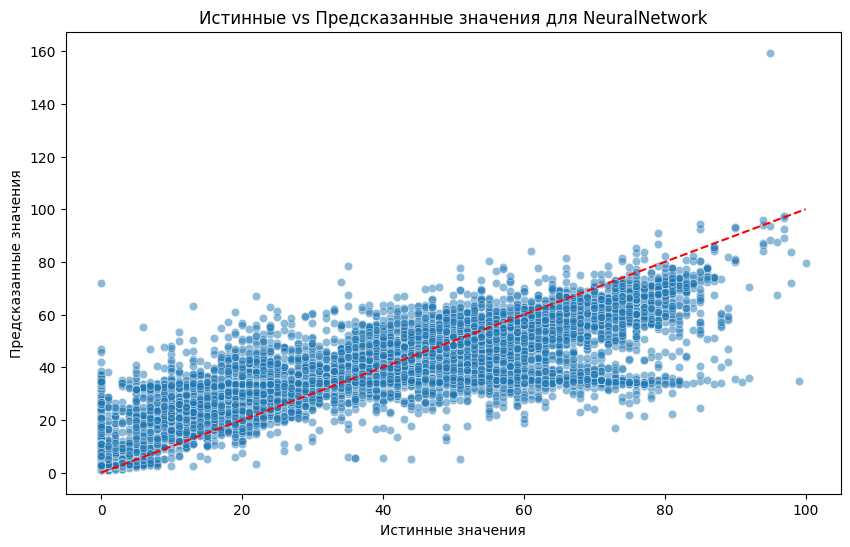

In [90]:
# Визуализация предсказаний против истинных значений
plt.figure(figsize=(10,6))
sns.scatterplot(x=y_test_actual, y=y_pred_actual, alpha=0.5)
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.title(f'Истинные vs Предсказанные значения для {best_model_name}')
plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], 'r--')
plt.show()

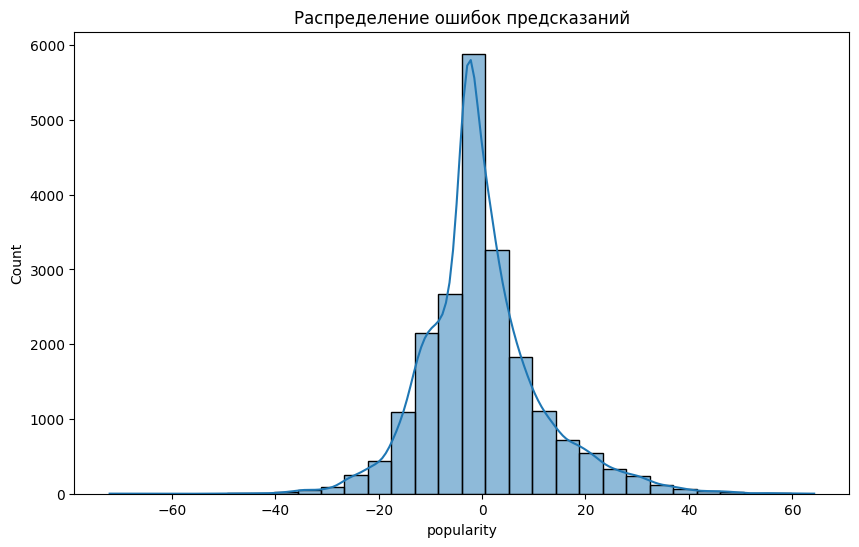

In [91]:
# Выводы о распределении ошибок
errors = y_test_actual - y_pred_actual
plt.figure(figsize=(10,6))
sns.histplot(errors, kde=True, bins=30)
plt.title('Распределение ошибок предсказаний')
plt.show()

## Итоговый вывод:
Мы удалили логарифмическое преобразование целевой переменной и обучили модели на исходных данных.

Провели предобработку данных, включая импутацию пропусков и кодирование категориальных признаков с помощью Target Encoding.

Обучили различные модели регрессии и нейросеть, провели гиперпараметрическую настройку.

Выбрали лучшую модель на основе RMSE на кросс-валидации и оценили её на тестовых данных.

Провели анализ ошибок для лучшей модели.
